In [10]:
# Cell 1: Enhanced Setup with Dependency Installation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from openpyxl import load_workbook
from math import ceil
from typing import List, Optional, Dict, Any
from dataclasses import dataclass
import warnings
from IPython.display import display, HTML
from scipy import stats

# Install missing packages if needed
try:
    import plotly.express as px
except ImportError:
    print("Installing required packages...")
    %pip install nbformat>=4.2.0 plotly
    import plotly.express as px

# Enhanced configuration
@dataclass
class VisualizationConfig:
    excel_file_path: str = r'F:\GP\ML\LiveData\LiveData.xlsx'
    session_to_visualize: str = 'Session_20250612_205539'
    x_axis_column: str = 'TimeWithFace'
    plot_style: str = 'seaborn-v0_8-whitegrid'
    grid_plot_cols: int = 3
    grid_plot_figsize: tuple = (20, 5)
    custom_plot_figsize: tuple = (15, 7)
    excluded_columns: List[str] = None
    correlation_threshold: float = 0.7
    outlier_threshold: float = 3.0  # Z-score threshold for outliers
    movement_threshold_mm: float = 5.0  # Threshold for extreme movements
    
    def __post_init__(self):
        if self.excluded_columns is None:
            self.excluded_columns = ['Index', 'Label', 'Prediction', 'TotalTime', self.x_axis_column]

# Initialize with validation
try:
    config = VisualizationConfig()
    print("✅ Configuration loaded successfully")
except Exception as e:
    print(f"❌ Configuration error: {str(e)}")
    config = VisualizationConfig()

# Visualization setup
%matplotlib inline
plt.style.use(config.plot_style)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore', category=UserWarning)

✅ Configuration loaded successfully


In [11]:
# Cell 2: Enhanced Data Loader with Outlier Detection
class DataLoader:
    """Now includes outlier detection during loading"""
    
    @staticmethod
    def list_available_sessions(file_path: str) -> List[str]:
        """Lists available sessions with improved error handling"""
        if not os.path.exists(file_path):
            print(f"❌ Error: File not found at '{file_path}'")
            return []
            
        try:
            workbook = load_workbook(filename=file_path, read_only=True)
            session_sheets = [sheet for sheet in workbook.sheetnames 
                            if sheet.startswith("Session_")]
            workbook.close()
            return sorted(session_sheets)
        except Exception as e:
            print(f"❌ Error reading Excel file: {str(e)}")
            return []
    
    @staticmethod
    def load_session_data(file_path: str, sheet_name: str, 
                         x_axis_col: str, config: VisualizationConfig) -> Optional[pd.DataFrame]:
        """Enhanced loading with outlier detection"""
        print(f"⚙️ Loading session: '{sheet_name}' with outlier detection...")
        
        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
            
            # Data validation
            if df.empty:
                raise ValueError("Empty DataFrame")
                
            if x_axis_col not in df.columns:
                raise ValueError(f"X-axis column '{x_axis_col}' not found")
            
            # Clean data
            df = df.iloc[1:].copy() if len(df) > 1 else df.copy()
            df = df.reset_index(drop=True)
            
            # Convert x-axis
            df[x_axis_col] = pd.to_numeric(df[x_axis_col], errors='coerce')
            if df[x_axis_col].isnull().any():
                nan_count = df[x_axis_col].isnull().sum()
                df = df.dropna(subset=[x_axis_col]).copy()
                print(f"⚠️ Removed {nan_count} rows with invalid time values")
            
            # Optimize numeric columns
            numeric_cols = df.select_dtypes(include=np.number).columns
            df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
            
            # Add outlier flags
            movement_cols = [c for c in df.columns if 'Magnitude' in c]
            for col in movement_cols:
                z_scores = np.abs(stats.zscore(df[col]))
                df[f'{col}_Outlier'] = z_scores > config.outlier_threshold
            
            print(f"✅ Successfully loaded '{sheet_name}' with {len(df)} rows")
            print(f"🔍 Found {df[[f'{c}_Outlier' for c in movement_cols]].sum().sum()} potential outliers")
            return df
            
        except Exception as e:
            print(f"❌ Failed to load sheet '{sheet_name}': {str(e)}")
            return None

# Display available sessions
print("\n--- Available Sessions ---")
sessions = DataLoader.list_available_sessions(config.excel_file_path)
if sessions:
    for i, session in enumerate(sessions, 1):
        print(f"{i:2d}. {session}")
else:
    print("No sessions found")



--- Available Sessions ---
 1. Session_20250610_184239
 2. Session_20250610_184454
 3. Session_20250610_184515
 4. Session_20250610_184555
 5. Session_20250610_184616
 6. Session_20250610_184645
 7. Session_20250610_185032
 8. Session_20250610_185114
 9. Session_20250610_185456
10. Session_20250610_185551
11. Session_20250610_185654
12. Session_20250610_191336
13. Session_20250610_191446
14. Session_20250612_112801
15. Session_20250612_112848
16. Session_20250612_113153
17. Session_20250612_113224
18. Session_20250612_113742
19. Session_20250612_113808
20. Session_20250612_113837
21. Session_20250612_114749
22. Session_20250612_115157
23. Session_20250612_150308
24. Session_20250612_194245
25. Session_20250612_194408
26. Session_20250612_194457
27. Session_20250612_194614
28. Session_20250612_194713
29. Session_20250612_203635
30. Session_20250612_203733
31. Session_20250612_204120
32. Session_20250612_204430
33. Session_20250612_204601
34. Session_20250612_205539
35. Session_20250612

In [12]:
# Cell 3: Advanced Visualizer with New Features
class DataVisualizer:
    """Now includes interactive plots and outlier visualization"""
    
    @staticmethod
    def create_grid_plot(df: pd.DataFrame, config: VisualizationConfig) -> None:
        """Enhanced with outlier markers"""
        if df is None or df.empty:
            print("⚠️ No data available")
            return
            
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        features = [col for col in numeric_cols 
                   if col not in config.excluded_columns 
                   and not col.endswith('_Outlier')]
        
        if not features:
            print("⚠️ No features available")
            return
            
        n_rows = ceil(len(features) / config.grid_plot_cols)
        fig, axes = plt.subplots(
            n_rows, config.grid_plot_cols,
            figsize=(config.grid_plot_figsize[0], 
                    config.grid_plot_figsize[1] * n_rows)
        )
        fig.suptitle(
            f"Dashboard: {config.session_to_visualize}\n(Red dots = outliers)",
            fontsize=16, 
            y=1.02
        )
        
        axes = axes.flatten() if n_rows > 1 else [axes]
        
        for i, feature in enumerate(features):
            ax = axes[i]
            
            # Main plot
            sns.lineplot(
                data=df, 
                x=config.x_axis_column, 
                y=feature,
                ax=ax,
                linewidth=1,
                color='royalblue'
            )
            
            # Add outlier markers if available
            outlier_col = f'{feature}_Outlier'
            if outlier_col in df.columns:
                outliers = df[df[outlier_col]]
                ax.scatter(
                    outliers[config.x_axis_column],
                    outliers[feature],
                    color='red',
                    s=20,
                    label='Outlier'
                )
            
            # Formatting
            ax.set_title(feature, fontsize=12, pad=10)
            ax.set_xlabel(config.x_axis_column, fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.5)
            
            if len(df) > 10:
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
            
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def create_interactive_plot(df: pd.DataFrame, features: List[str], title: str) -> None:
        """New interactive plot using Plotly"""
        if df is None or df.empty:
            print("⚠️ No data available")
            return
            
        available = [f for f in features if f in df.columns]
        if not available:
            print("⚠️ No features available")
            return
            
        fig = px.line(
            df, 
            x=config.x_axis_column, 
            y=available,
            title=title,
            template='plotly_white'
        )
        
        # Add outlier markers if available
        for feature in available:
            outlier_col = f'{feature}_Outlier'
            if outlier_col in df.columns:
                outliers = df[df[outlier_col]]
                fig.add_scatter(
                    x=outliers[config.x_axis_column],
                    y=outliers[feature],
                    mode='markers',
                    marker=dict(color='red', size=6),
                    name=f'{feature} Outlier',
                    showlegend=True
                )
        
        fig.update_layout(
            hovermode='x unified',
            legend=dict(orientation='h', y=1.1)
        )
        fig.show()
    
    @staticmethod
    def plot_selected_features(df: pd.DataFrame, features: List[str], title: str, config: VisualizationConfig) -> None:
        """Plots selected features on a single graph"""
        if df is None or df.empty:
            print("⚠️ No data available")
            return
            
        plt.figure(figsize=config.custom_plot_figsize)
        
        for feature in features:
            if feature in df.columns:
                plt.plot(df[config.x_axis_column], df[feature], label=feature)
            else:
                print(f"Warning: Feature '{feature}' not found")
        
        plt.title(title, fontsize=14)
        plt.xlabel(config.x_axis_column)
        plt.ylabel("Value")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def show_statistics(df: pd.DataFrame) -> None:
        """Enhanced with interactive HTML output"""
        if df is None or df.empty:
            print("⚠️ No data available")
            return
            
        numeric_cols = df.select_dtypes(include=np.number).columns
        stats = df[numeric_cols].describe().T
        stats['IQR'] = stats['75%'] - stats['25%']
        stats['Outlier_Count'] = 0
        
        # Count outliers
        for col in numeric_cols:
            outlier_col = f'{col}_Outlier'
            if outlier_col in df.columns:
                stats.loc[col, 'Outlier_Count'] = df[outlier_col].sum()
        
        # Create styled output
        styled_stats = stats[['mean', 'std', 'min', '50%', 'max', 'IQR', 'Outlier_Count']]\
            .style\
            .format("{:.2f}")\
            .background_gradient(cmap='Blues', subset=['mean', 'std'])\
            .background_gradient(cmap='Reds', subset=['IQR', 'Outlier_Count'])\
            .set_caption("Enhanced Statistics with Outlier Counts")
        
        display(styled_stats)
    
    @staticmethod
    def plot_movement_analysis(df: pd.DataFrame, config: VisualizationConfig) -> None:
        """New dedicated movement analysis"""
        if df is None or df.empty:
            print("⚠️ No data available")
            return
            
        movement_cols = [c for c in df.columns if 'Magnitude' in c and not c.endswith('_Outlier')]
        if not movement_cols:
            print("⚠️ No movement data available")
            return
            
        plt.figure(figsize=(15, 8))
        
        for col in movement_cols:
            # Plot movement with threshold line
            plt.plot(df[config.x_axis_column], df[col], label=col)
            plt.axhline(y=config.movement_threshold_mm, color='r', linestyle='--', 
                       label='Threshold' if col == movement_cols[0] else "")
            
            # Highlight extreme movements
            extremes = df[df[col] > config.movement_threshold_mm]
            plt.scatter(extremes[config.x_axis_column], extremes[col], 
                       color='red', s=30, label='Extreme' if col == movement_cols[0] else "")
        
        plt.title(f"Movement Analysis (Threshold = {config.movement_threshold_mm}mm)", fontsize=14)
        plt.xlabel(config.x_axis_column)
        plt.ylabel("Movement (mm)")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

⚙️ Loading session: 'Session_20250612_205539' with outlier detection...
✅ Successfully loaded 'Session_20250612_205539' with 271 rows
🔍 Found 32 potential outliers

🚀 Generating enhanced dashboard...


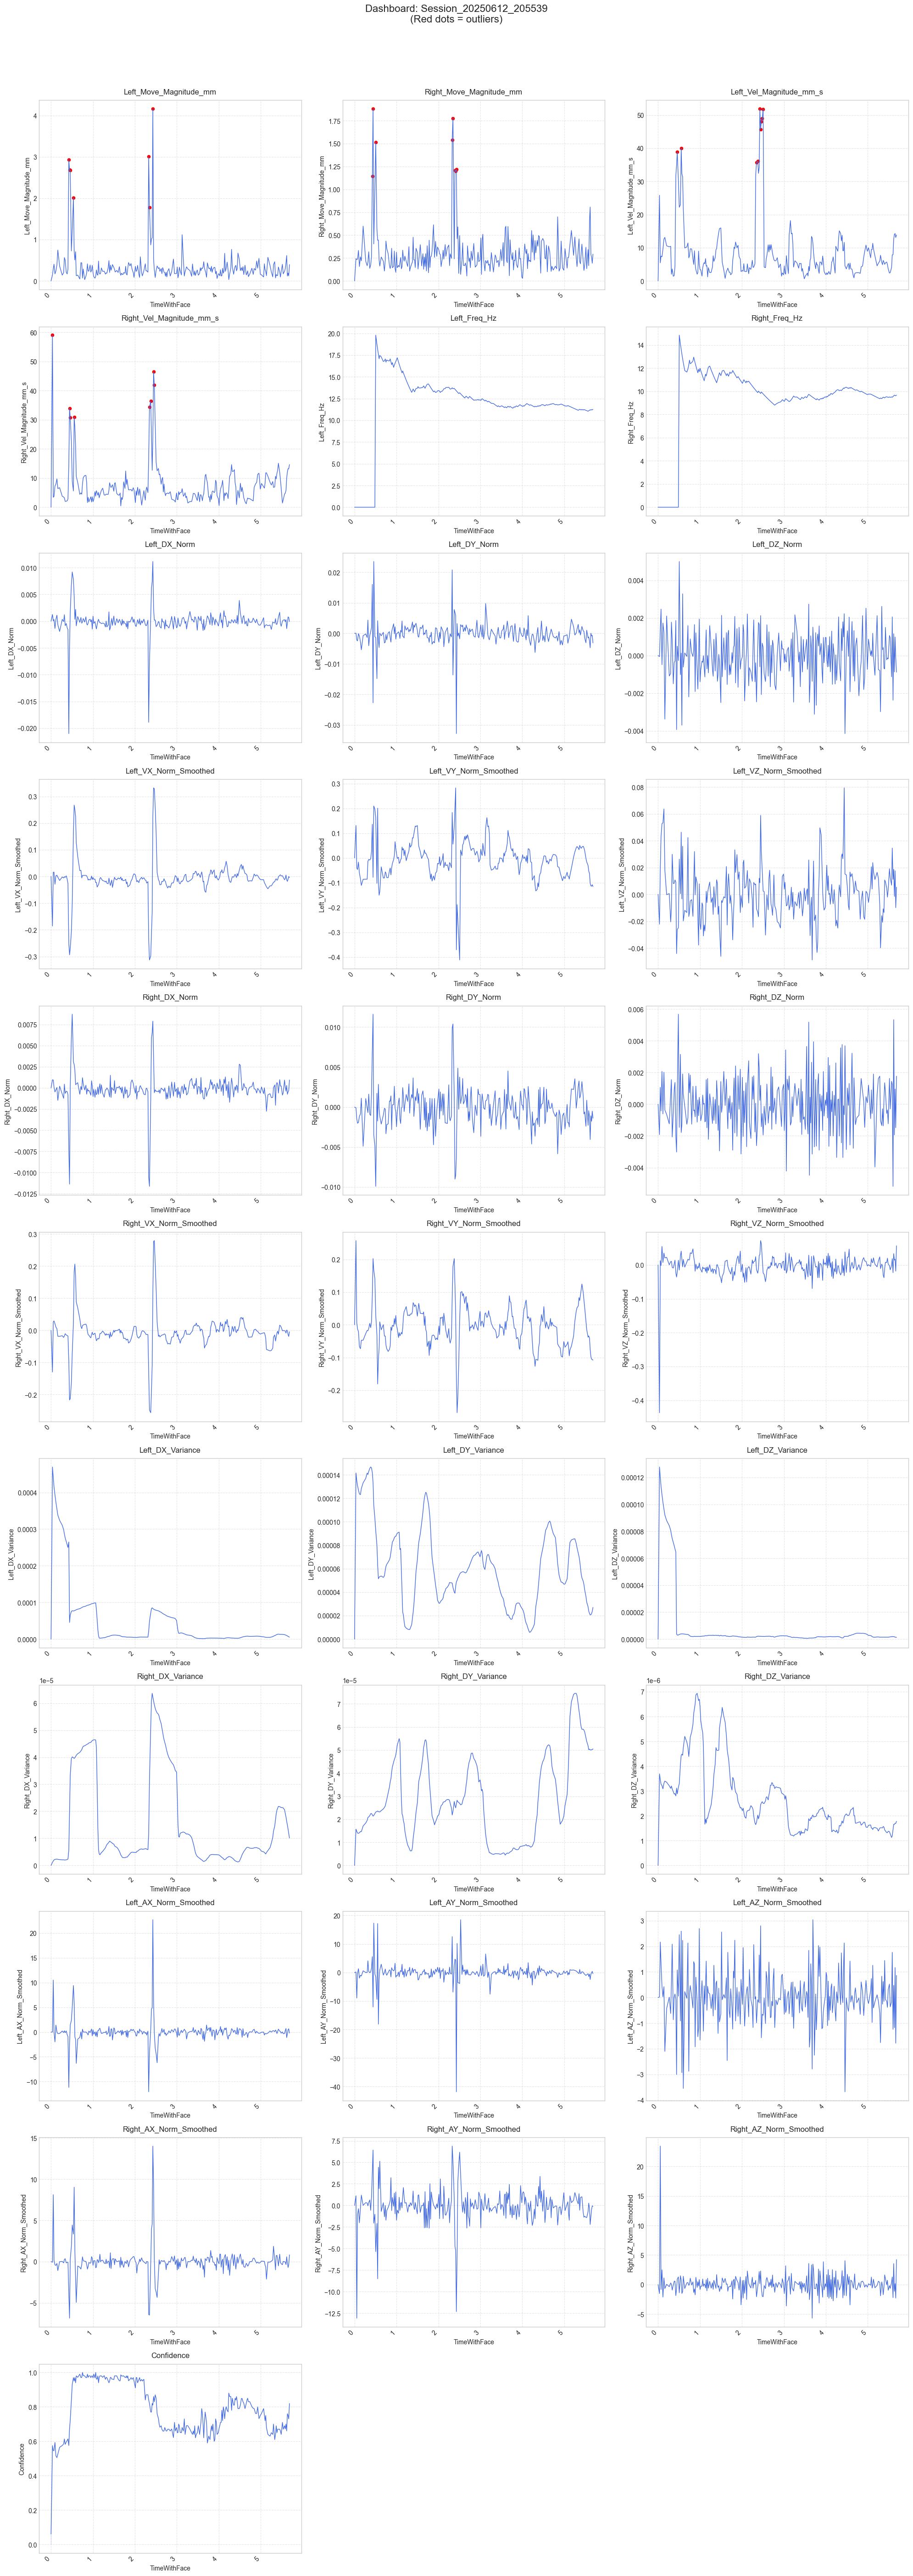


🔄 Generating interactive plot...

❌ Error in dashboard generation: Mime type rendering requires nbformat>=4.2.0 but it is not installed


In [13]:

# Cell 4: Main Dashboard with New Features
try:
    # Load data with outlier detection
    session_df = DataLoader.load_session_data(
        config.excel_file_path,
        config.session_to_visualize,
        config.x_axis_column,
        config
    )
    
    if session_df is not None:
        print("\n🚀 Generating enhanced dashboard...")
        
        # 1. Standard grid plot
        DataVisualizer.create_grid_plot(session_df, config)
        
        # 2. Interactive plot
        print("\n🔄 Generating interactive plot...")
        DataVisualizer.create_interactive_plot(
            session_df,
            ['Left_Move_Magnitude_mm', 'Right_Move_Magnitude_mm'],
            "Interactive Movement Comparison"
        )
        
        # 3. Movement-specific analysis
        print("\n📏 Running movement analysis...")
        DataVisualizer.plot_movement_analysis(session_df, config)
        
except Exception as e:
    print(f"\n❌ Error in dashboard generation: {str(e)}")



📊 Generating advanced custom visualizations...


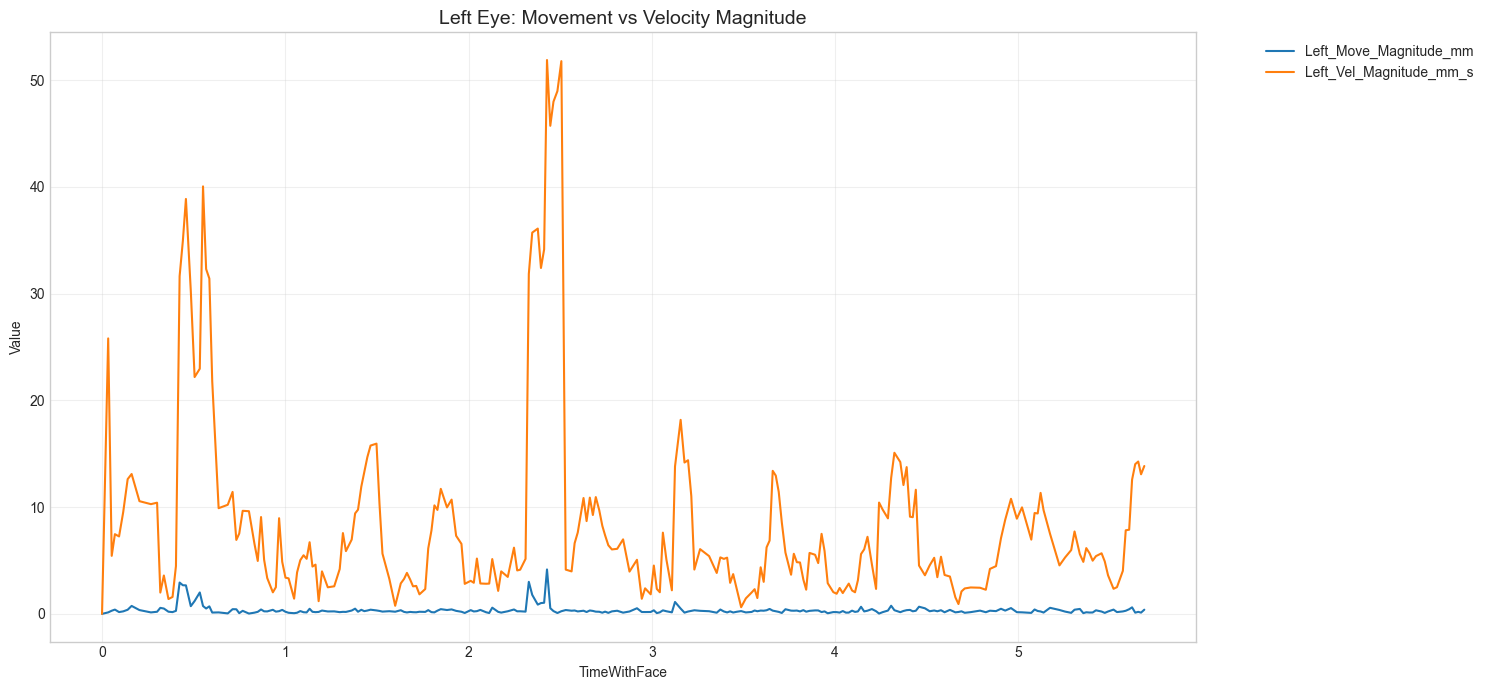

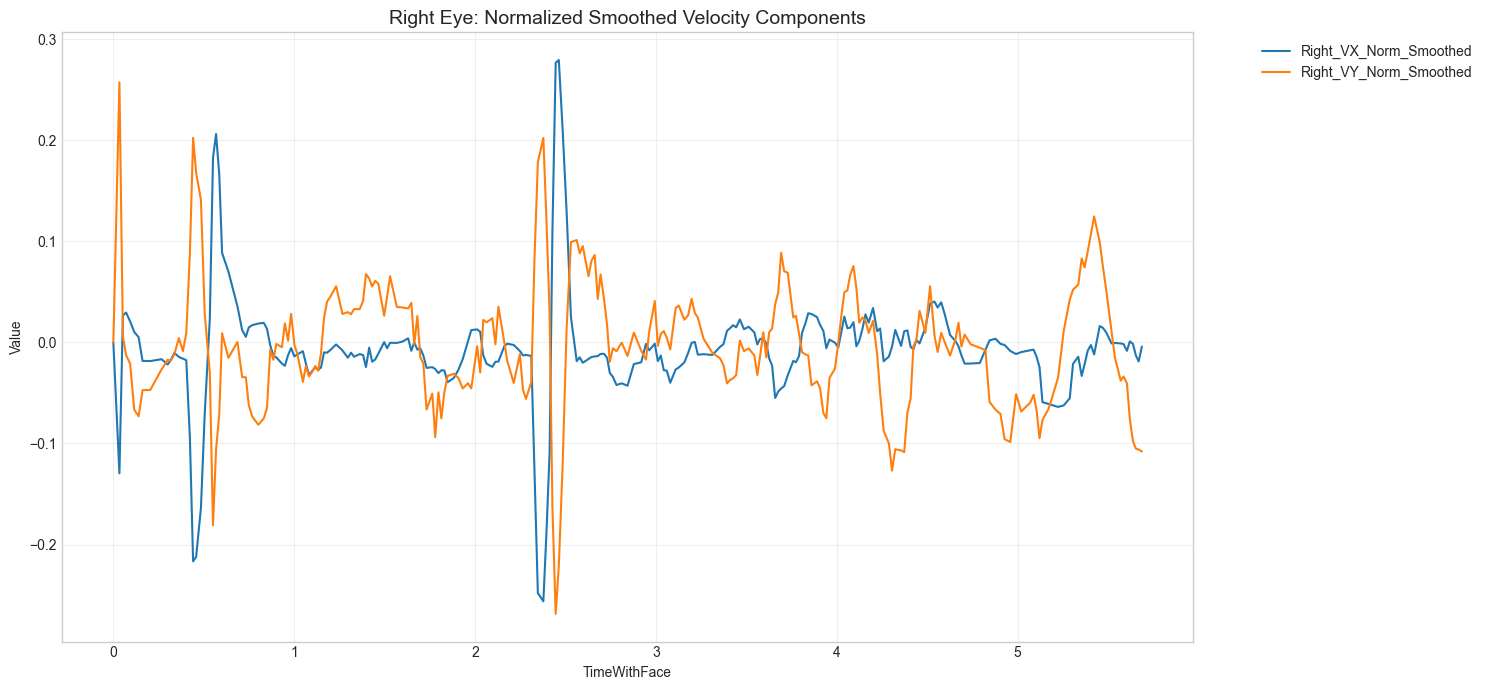

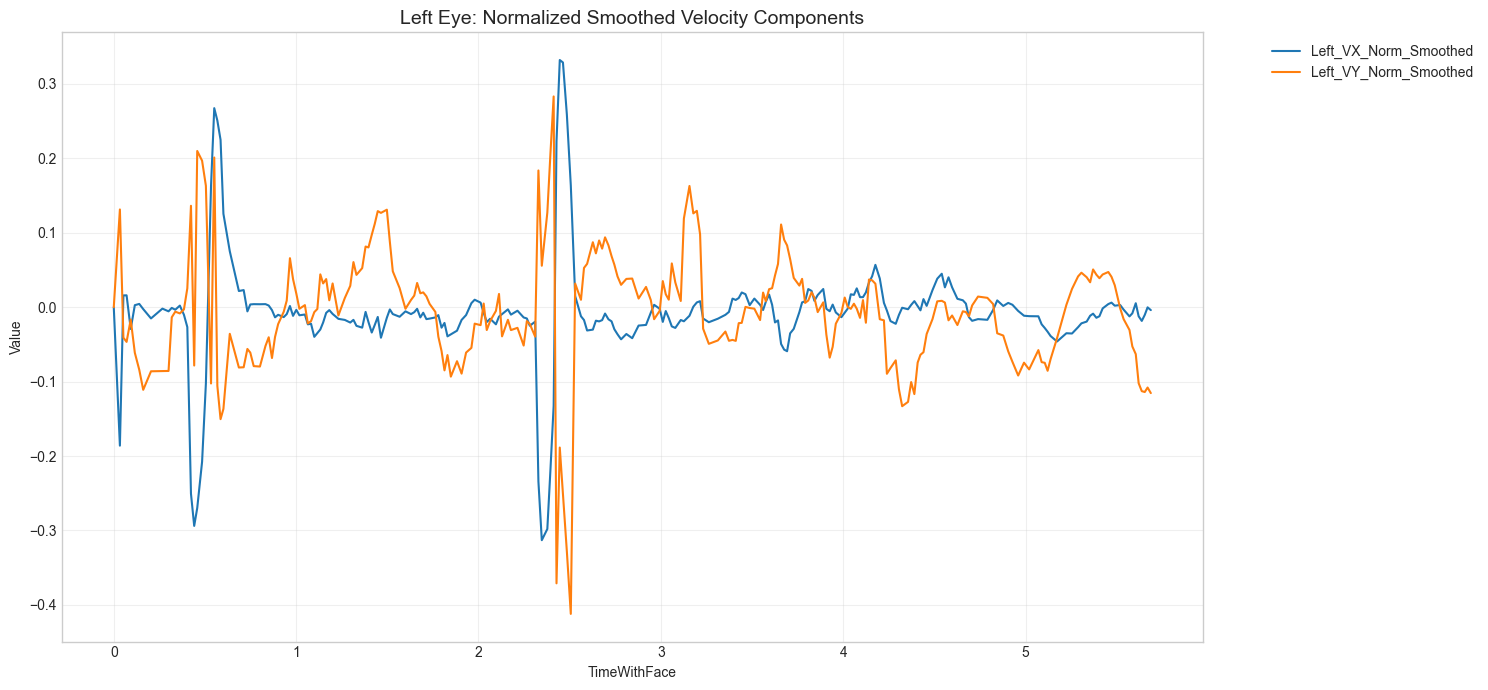

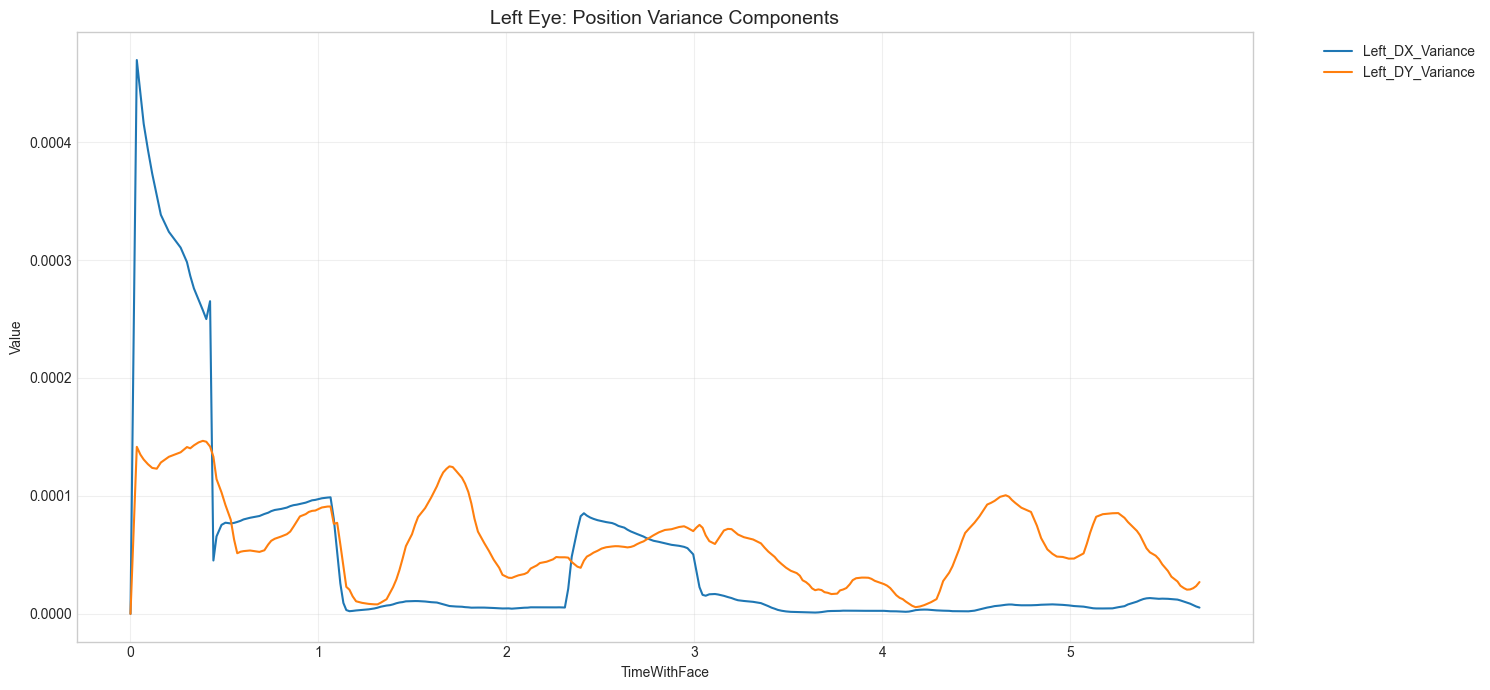

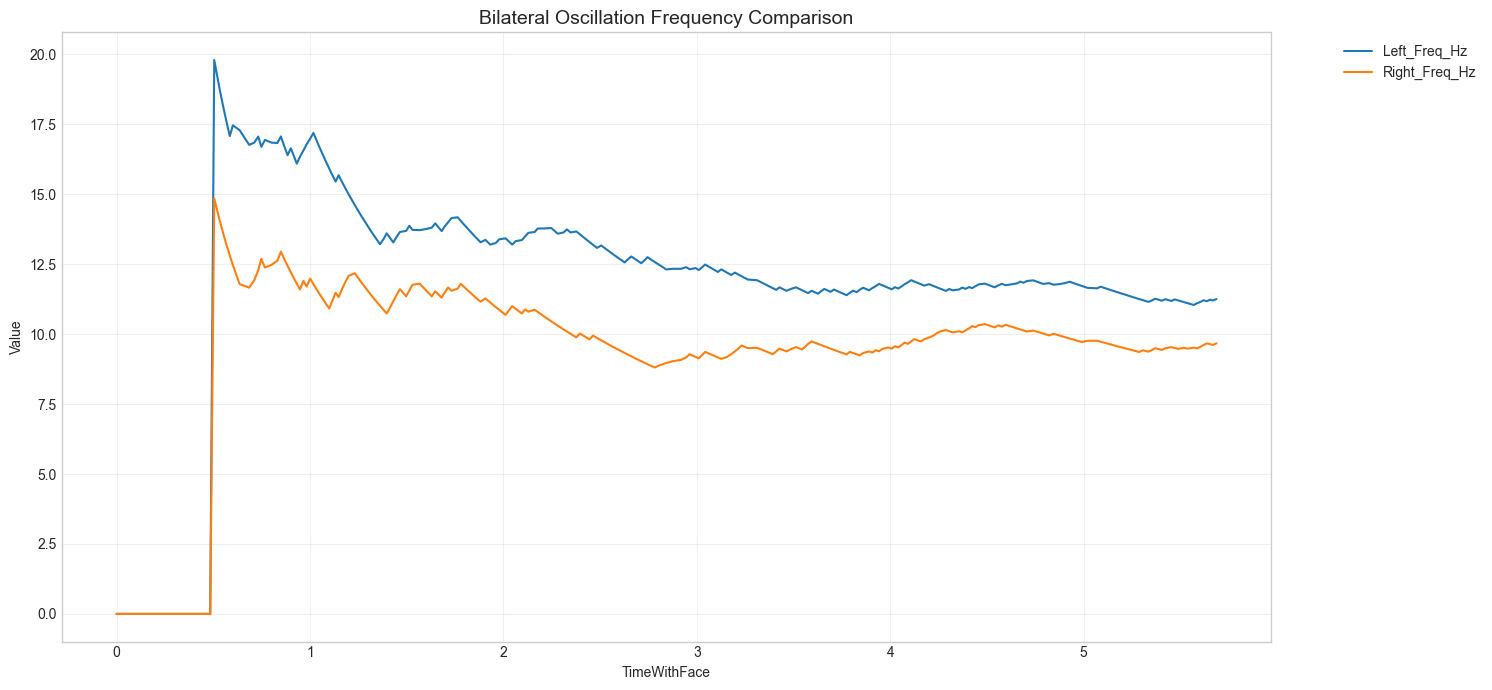

In [14]:
# Cell 5: Advanced Custom Visualizations
if 'session_df' in locals() and session_df is not None:
    print("\n📊 Generating advanced custom visualizations...")
    
    # 1. Movement vs Velocity Comparison
    DataVisualizer.plot_selected_features(
        df=session_df,
        features=['Left_Move_Magnitude_mm', 'Left_Vel_Magnitude_mm_s'],
        title="Left Eye: Movement vs Velocity Magnitude",
        config=config
    )
    
    # 2. Smoothed Velocity Components
    DataVisualizer.plot_selected_features(
        df=session_df,
        features=['Right_VX_Norm_Smoothed', 'Right_VY_Norm_Smoothed'],
        title="Right Eye: Normalized Smoothed Velocity Components",
        config=config
    )
    DataVisualizer.plot_selected_features(
        df=session_df,
        features=['Left_VX_Norm_Smoothed', 'Left_VY_Norm_Smoothed'],
        title="Left Eye: Normalized Smoothed Velocity Components",
        config=config
    )
    
    # 3. Variance Comparison
    DataVisualizer.plot_selected_features(
        df=session_df,
        features=['Left_DX_Variance', 'Left_DY_Variance'],
        title="Left Eye: Position Variance Components",
        config=config
    )
    
    # 4. Custom Frequency Analysis
    DataVisualizer.plot_selected_features(
        df=session_df,
        features=['Left_Freq_Hz', 'Right_Freq_Hz'],
        title="Bilateral Oscillation Frequency Comparison",
        config=config
    )
    
    # 5. Additional professional visualization
    if 'Left_Pupil_Diameter_mm' in session_df.columns:
        DataVisualizer.plot_selected_features(
            df=session_df,
            features=['Left_Pupil_Diameter_mm', 'Right_Pupil_Diameter_mm'],
            title="Bilateral Pupil Diameter Comparison",
            config=config
        )
else:
    print("\nℹ️ No data available for visualization - please run Cell 4 first")


In [15]:
# Cell 6: Fixed Comprehensive Analytics
if 'session_df' in locals() and session_df is not None:
    print("\n🔍 Running comprehensive analysis...")
    
    # 1. Enhanced statistics
    print("\n📈 Enhanced Statistics:")
    DataVisualizer.show_statistics(session_df)
    
    # 2. Correlation analysis - FIXED VERSION
    print("\n📊 Feature Correlations:")
    try:
        # Select only numeric columns excluding outliers and time index
        numeric_cols = session_df.select_dtypes(include=np.number).columns
        exclude_cols = [c for c in numeric_cols 
                       if '_Outlier' in c or c == config.x_axis_column or c == 'Index']
        corr_cols = [c for c in numeric_cols if c not in exclude_cols]
        
        if len(corr_cols) < 2:
            print("⚠️ Not enough numeric columns for correlation analysis")
        else:
            # Calculate correlation matrix
            corr_matrix = session_df[corr_cols].corr()
            
            # Display full matrix with styling
            print("Full Correlation Matrix:")
            styled_corr = corr_matrix.style\
                .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)\
                .format("{:.2f}")\
                .set_caption(f"Feature Correlations (Threshold = {config.correlation_threshold})")
            display(styled_corr)
            
            # Display only significant correlations
            mask = np.abs(corr_matrix) >= config.correlation_threshold
            np.fill_diagonal(mask.values, False)  # Exclude diagonal
            
            if mask.sum().sum() > 0:
                print(f"\nSignificant Correlations (|r| ≥ {config.correlation_threshold}):")
                significant_corrs = corr_matrix.where(mask).stack().reset_index()
                significant_corrs.columns = ['Feature 1', 'Feature 2', 'Correlation']
                significant_corrs = significant_corrs.dropna()
                display(significant_corrs.sort_values('Correlation', key=abs, ascending=False))
            else:
                print(f"\nNo significant correlations found (|r| ≥ {config.correlation_threshold})")
                
    except Exception as e:
        print(f"❌ Error in correlation analysis: {str(e)}")
    
    # 3. Outlier inspection
    print("\n🔎 Outlier Inspection:")
    outlier_cols = [col for col in session_df.columns if '_Outlier' in col]
    if outlier_cols:
        outlier_summary = session_df[outlier_cols].sum().sort_values(ascending=False)
        display(outlier_summary.to_frame(name="Outlier Count"))
        
        # Show extreme movement examples
        extreme_movements = session_df[
            (session_df['Left_Move_Magnitude_mm'] > config.movement_threshold_mm) |
            (session_df['Right_Move_Magnitude_mm'] > config.movement_threshold_mm)
        ]
        if not extreme_movements.empty:
            print(f"\n⚠️ Found {len(extreme_movements)} extreme movements (> {config.movement_threshold_mm}mm):")
            display(extreme_movements[[
                config.x_axis_column,
                'Left_Move_Magnitude_mm', 
                'Right_Move_Magnitude_mm',
                'Left_Move_Magnitude_mm_Outlier',
                'Right_Move_Magnitude_mm_Outlier'
            ]].head())
    
else:
    print("\nℹ️ No data available - please run Cell 4 first")



🔍 Running comprehensive analysis...

📈 Enhanced Statistics:


,mean,std,min,50%,max,IQR,Outlier_Count
Index,136.00,78.38,1.00,136.00,271.00,135.00,0.00
TotalTime,2.95,1.71,0.07,2.94,5.93,2.90,0.00
TimeWithFace,2.71,1.70,0.00,2.69,5.69,2.90,0.00
Left_Move_Magnitude_mm,0.33,0.45,0.00,0.24,4.16,0.19,7.00
Right_Move_Magnitude_mm,0.29,0.25,0.00,0.24,1.88,0.20,8.00
Left_Vel_Magnitude_mm_s,8.18,9.17,0.00,5.41,51.88,6.82,9.00
Right_Vel_Magnitude_mm_s,7.12,7.33,0.00,5.22,59.00,5.03,8.00
Left_Freq_Hz,11.33,4.62,0.00,11.84,19.80,2.05,0.00
Right_Freq_Hz,9.01,3.57,0.00,9.72,14.85,1.54,0.00
Left_DX_Norm,-0.00,0.00,-0.02,-0.00,0.01,0.00,0.00



📊 Feature Correlations:
Full Correlation Matrix:


,TotalTime,Left_Move_Magnitude_mm,Right_Move_Magnitude_mm,Left_Vel_Magnitude_mm_s,Right_Vel_Magnitude_mm_s,Left_Freq_Hz,Right_Freq_Hz,Left_DX_Norm,Left_DY_Norm,Left_DZ_Norm,Left_VX_Norm_Smoothed,Left_VY_Norm_Smoothed,Left_VZ_Norm_Smoothed,Right_DX_Norm,Right_DY_Norm,Right_DZ_Norm,Right_VX_Norm_Smoothed,Right_VY_Norm_Smoothed,Right_VZ_Norm_Smoothed,Left_DX_Variance,Left_DY_Variance,Left_DZ_Variance,Right_DX_Variance,Right_DY_Variance,Right_DZ_Variance,Left_AX_Norm_Smoothed,Left_AY_Norm_Smoothed,Left_AZ_Norm_Smoothed,Right_AX_Norm_Smoothed,Right_AY_Norm_Smoothed,Right_AZ_Norm_Smoothed,Confidence,Label
TotalTime,1.00,-0.08,0.05,-0.10,0.01,0.28,0.38,0.01,-0.03,0.01,0.04,-0.09,0.03,0.00,-0.02,0.01,0.02,-0.08,0.08,-0.47,-0.20,-0.36,-0.17,0.34,-0.42,-0.02,-0.01,-0.01,-0.02,0.01,-0.04,0.08,nan
Left_Move_Magnitude_mm,-0.08,1.00,0.68,0.61,0.42,-0.02,-0.04,-0.14,-0.11,-0.02,-0.26,0.04,0.00,-0.14,0.13,-0.01,-0.27,0.14,0.05,0.14,0.17,0.06,0.20,-0.01,0.05,0.19,-0.22,-0.03,0.12,-0.08,0.00,0.11,nan
Right_Move_Magnitude_mm,0.05,0.68,1.00,0.55,0.45,0.10,0.09,-0.12,-0.16,-0.03,-0.33,0.07,0.01,-0.17,0.05,-0.01,-0.32,0.13,0.03,0.07,0.14,0.01,0.19,0.07,0.04,0.05,-0.16,-0.07,-0.00,-0.03,-0.02,0.21,nan
Left_Vel_Magnitude_mm_s,-0.10,0.61,0.55,1.00,0.80,0.09,0.05,0.06,-0.06,0.01,0.08,-0.15,0.09,0.04,0.06,-0.02,0.09,-0.07,0.02,0.21,0.12,0.06,0.46,0.00,0.13,0.14,-0.13,-0.01,0.15,-0.00,-0.03,0.20,nan
Right_Vel_Magnitude_mm_s,0.01,0.42,0.45,0.80,1.00,0.05,0.03,0.04,-0.03,-0.03,-0.02,-0.08,0.02,-0.04,0.11,-0.06,-0.00,0.04,-0.25,0.21,0.12,0.11,0.36,0.09,0.08,0.08,-0.03,-0.01,0.09,0.03,-0.04,0.17,nan
Left_Freq_Hz,0.28,-0.02,0.10,0.09,0.05,1.00,0.98,0.12,-0.03,-0.01,0.20,-0.02,-0.09,0.11,-0.04,-0.03,0.17,-0.13,0.08,-0.44,-0.11,-0.58,0.40,0.33,0.43,0.04,-0.03,0.00,0.05,0.00,-0.11,0.77,nan
Right_Freq_Hz,0.38,-0.04,0.09,0.05,0.03,0.98,1.00,0.12,-0.04,-0.00,0.20,-0.04,-0.07,0.11,-0.05,-0.03,0.17,-0.14,0.06,-0.51,-0.13,-0.60,0.27,0.33,0.36,0.03,-0.03,0.00,0.05,0.00,-0.11,0.78,nan
Left_DX_Norm,0.01,-0.14,-0.12,0.06,0.04,0.12,0.12,1.00,-0.33,0.10,0.36,-0.09,0.05,0.80,-0.52,0.12,0.22,-0.17,0.02,-0.05,-0.08,-0.10,0.18,-0.02,0.02,0.77,-0.24,0.11,0.63,-0.51,0.04,0.05,nan
Left_DY_Norm,-0.03,-0.11,-0.16,-0.06,-0.03,-0.03,-0.04,-0.33,1.00,0.10,-0.27,0.52,-0.05,-0.10,0.05,-0.01,-0.18,0.24,-0.05,-0.01,-0.00,-0.02,-0.01,0.01,0.01,-0.44,0.76,0.10,-0.19,0.12,-0.02,-0.03,nan
Left_DZ_Norm,0.01,-0.02,-0.03,0.01,-0.03,-0.01,-0.00,0.10,0.10,1.00,0.02,0.03,0.38,0.25,-0.21,0.21,0.04,-0.07,0.04,0.06,0.01,0.07,-0.01,-0.01,-0.03,0.09,0.12,0.68,0.15,-0.13,0.14,-0.02,nan



Significant Correlations (|r| ≥ 0.7):


,Feature 1,Feature 2,Correlation
2,Left_Freq_Hz,Right_Freq_Hz,0.98
4,Right_Freq_Hz,Left_Freq_Hz,0.98
12,Right_VX_Norm_Smoothed,Left_VX_Norm_Smoothed,0.96
9,Left_VX_Norm_Smoothed,Right_VX_Norm_Smoothed,0.96
13,Left_DX_Variance,Left_DZ_Variance,0.93
14,Left_DZ_Variance,Left_DX_Variance,0.93
20,Right_AX_Norm_Smoothed,Left_AX_Norm_Smoothed,0.87
16,Left_AX_Norm_Smoothed,Right_AX_Norm_Smoothed,0.87
6,Left_DX_Norm,Right_DX_Norm,0.80
10,Right_DX_Norm,Left_DX_Norm,0.80



🔎 Outlier Inspection:


,Outlier Count
Left_Vel_Magnitude_mm_s_Outlier,9
Right_Move_Magnitude_mm_Outlier,8
Right_Vel_Magnitude_mm_s_Outlier,8
Left_Move_Magnitude_mm_Outlier,7


In [16]:
# --- REPLACE YOUR ENTIRE CELL 3 DataVisualizer CLASS WITH THIS ---

class DataVisualizer:
    """Now includes interactive plots, outlier visualization, and heatmaps"""
    
    @staticmethod
    def create_grid_plot(df: pd.DataFrame, config: VisualizationConfig) -> None:
        """Enhanced with outlier markers"""
        if df is None or df.empty:
            print("⚠️ No data available")
            return
            
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        features = [col for col in numeric_cols 
                   if col not in config.excluded_columns 
                   and not col.endswith('_Outlier')]
        
        if not features:
            print("⚠️ No features available")
            return
            
        n_rows = ceil(len(features) / config.grid_plot_cols)
        fig, axes = plt.subplots(
            n_rows, config.grid_plot_cols,
            figsize=(config.grid_plot_figsize[0], 
                    config.grid_plot_figsize[1] * n_rows)
        )
        fig.suptitle(
            f"Dashboard: {config.session_to_visualize}\n(Red dots = outliers)",
            fontsize=16, 
            y=1.02
        )
        
        axes = axes.flatten() if n_rows > 1 else [axes]
        
        for i, feature in enumerate(features):
            ax = axes[i]
            sns.lineplot(
                data=df, 
                x=config.x_axis_column, 
                y=feature,
                ax=ax,
                linewidth=1,
                color='royalblue'
            )
            outlier_col = f'{feature}_Outlier'
            if outlier_col in df.columns:
                outliers = df[df[outlier_col]]
                ax.scatter(
                    outliers[config.x_axis_column],
                    outliers[feature],
                    color='red',
                    s=20,
                    label='Outlier'
                )
            ax.set_title(feature, fontsize=12, pad=10)
            ax.set_xlabel(config.x_axis_column, fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.5)
            if len(df) > 10:
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
            
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def create_interactive_plot(df: pd.DataFrame, features: List[str], title: str) -> None:
        """New interactive plot using Plotly"""
        if df is None or df.empty: return
        available = [f for f in features if f in df.columns]
        if not available: return
        fig = px.line(df, x=config.x_axis_column, y=available, title=title, template='plotly_white')
        for feature in available:
            outlier_col = f'{feature}_Outlier'
            if outlier_col in df.columns:
                outliers = df[df[outlier_col]]
                fig.add_scatter(x=outliers[config.x_axis_column], y=outliers[feature], mode='markers', marker=dict(color='red', size=6), name=f'{feature} Outlier')
        fig.update_layout(hovermode='x unified', legend=dict(orientation='h', y=1.1))
        fig.show()
    
    @staticmethod
    def plot_selected_features(df: pd.DataFrame, features: List[str], title: str, config: VisualizationConfig) -> None:
        """Plots selected features on a single graph"""
        if df is None or df.empty: return
        plt.figure(figsize=config.custom_plot_figsize)
        for feature in features:
            if feature in df.columns:
                plt.plot(df[config.x_axis_column], df[feature], label=feature)
        plt.title(title, fontsize=14)
        plt.xlabel(config.x_axis_column)
        plt.ylabel("Value")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def show_statistics(df: pd.DataFrame) -> None:
        """Enhanced with interactive HTML output"""
        if df is None or df.empty: return
        numeric_cols = df.select_dtypes(include=np.number).columns
        stats = df[numeric_cols].describe().T
        stats['IQR'] = stats['75%'] - stats['25%']
        stats['Outlier_Count'] = 0
        for col in numeric_cols:
            outlier_col = f'{col}_Outlier'
            if outlier_col in df.columns:
                stats.loc[col, 'Outlier_Count'] = df[outlier_col].sum()
        styled_stats = stats[['mean', 'std', 'min', '50%', 'max', 'IQR', 'Outlier_Count']]\
            .style.format("{:.2f}").background_gradient(cmap='Blues', subset=['mean', 'std'])\
            .background_gradient(cmap='Reds', subset=['IQR', 'Outlier_Count'])\
            .set_caption("Enhanced Statistics with Outlier Counts")
        display(styled_stats)
    
    @staticmethod
    def plot_movement_analysis(df: pd.DataFrame, config: VisualizationConfig) -> None:
        """New dedicated movement analysis"""
        if df is None or df.empty: return
        movement_cols = [c for c in df.columns if 'Magnitude' in c and not c.endswith('_Outlier')]
        if not movement_cols: return
        plt.figure(figsize=(15, 8))
        for col in movement_cols:
            plt.plot(df[config.x_axis_column], df[col], label=col)
            plt.axhline(y=config.movement_threshold_mm, color='r', linestyle='--', label='Threshold' if col == movement_cols[0] else "")
            extremes = df[df[col] > config.movement_threshold_mm]
            plt.scatter(extremes[config.x_axis_column], extremes[col], color='red', s=30, label='Extreme' if col == movement_cols[0] else "")
        plt.title(f"Movement Analysis (Threshold = {config.movement_threshold_mm}mm)", fontsize=14)
        plt.xlabel(config.x_axis_column)
        plt.ylabel("Movement (mm)")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # --- NEW FUNCTION, CORRECTLY INDENTED ---
    @staticmethod
    def create_correlation_heatmap(df: pd.DataFrame, config: VisualizationConfig) -> None:
        """
        Generates a professional heatmap of the feature correlation matrix.
        """
        print("📊 Generating Correlation Heatmap...")
        if df is None or df.empty:
            print("⚠️ No data available for heatmap.")
            return

        try:
            numeric_cols = df.select_dtypes(include=np.number).columns
            exclude_cols = [c for c in numeric_cols 
                           if '_Outlier' in c or c == config.x_axis_column or c == 'Index' or 'Variance' in c]
            corr_cols = [c for c in numeric_cols if c not in exclude_cols]

            if len(corr_cols) < 2:
                print("⚠️ Not enough numeric columns to generate a correlation heatmap.")
                return

            corr_matrix = df[corr_cols].corr()

            plt.figure(figsize=(18, 15))
            sns.heatmap(
                corr_matrix, 
                annot=False,
                cmap='Spectral_r',
                linewidths=.5,
                fmt=".2f",
                vmin=-1,
                vmax=1
            )
            
            plt.title('Feature Correlation Heatmap', fontsize=20, pad=20)
            plt.xticks(rotation=90)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ An error occurred while generating the heatmap: {str(e)}")

,mean,std,min,50%,max,IQR,Outlier_Count
Index,136.00,78.38,1.00,136.00,271.00,135.00,0.00
TotalTime,2.95,1.71,0.07,2.94,5.93,2.90,0.00
TimeWithFace,2.71,1.70,0.00,2.69,5.69,2.90,0.00
Left_Move_Magnitude_mm,0.33,0.45,0.00,0.24,4.16,0.19,7.00
Right_Move_Magnitude_mm,0.29,0.25,0.00,0.24,1.88,0.20,8.00
Left_Vel_Magnitude_mm_s,8.18,9.17,0.00,5.41,51.88,6.82,9.00
Right_Vel_Magnitude_mm_s,7.12,7.33,0.00,5.22,59.00,5.03,8.00
Left_Freq_Hz,11.33,4.62,0.00,11.84,19.80,2.05,0.00
Right_Freq_Hz,9.01,3.57,0.00,9.72,14.85,1.54,0.00
Left_DX_Norm,-0.00,0.00,-0.02,-0.00,0.01,0.00,0.00


📊 Generating Correlation Heatmap...


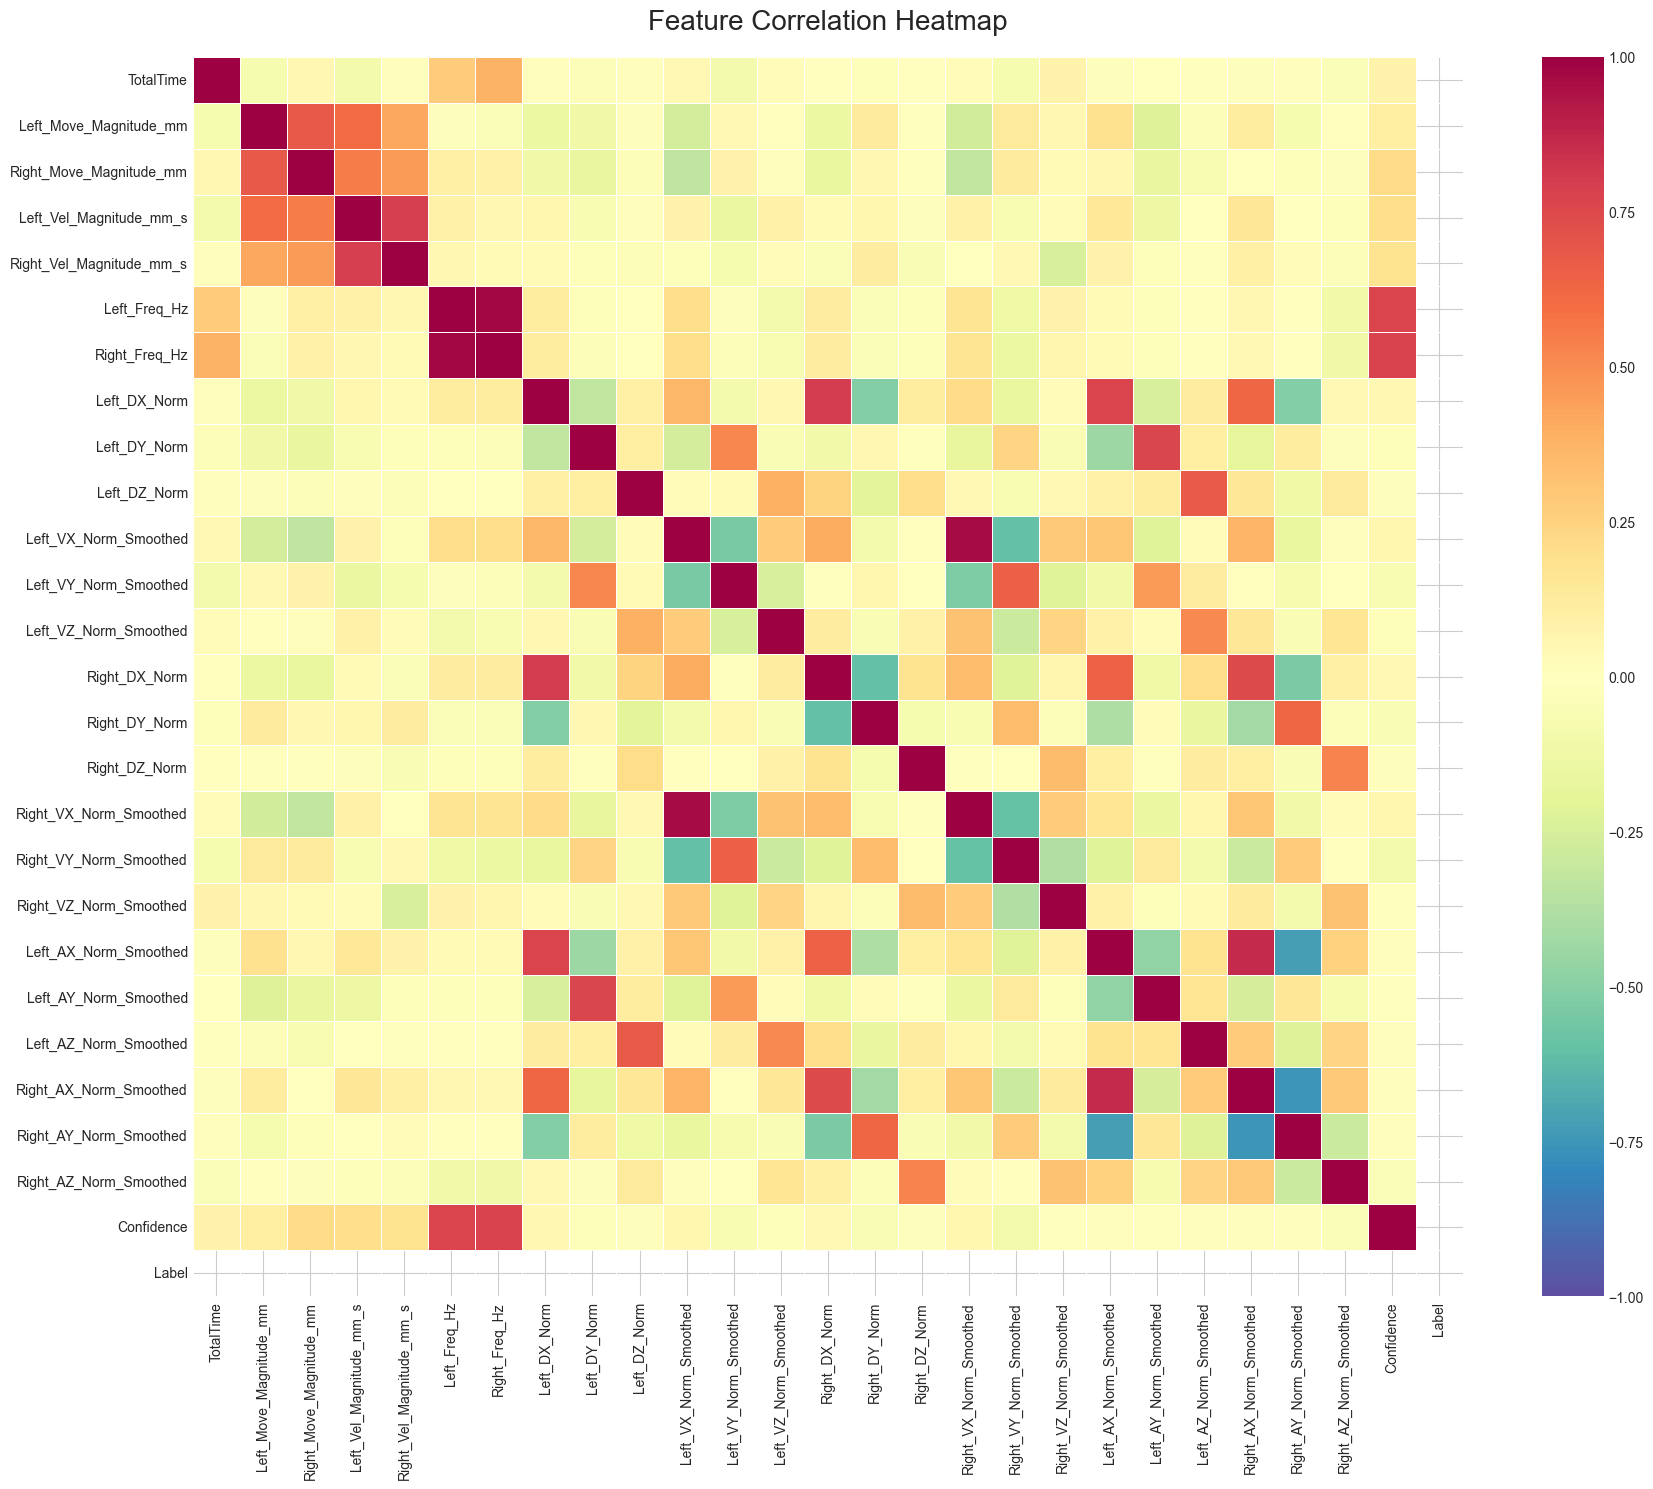


📊 Feature Correlations:


In [17]:
# --- CHECK THE INDENTATION OF THIS LINE IN CELL 6 ---

if 'session_df' in locals() and session_df is not None:
    # ...
    DataVisualizer.show_statistics(session_df)
    
    # This line must be indented to the same level as the line above it
    DataVisualizer.create_correlation_heatmap(session_df, config)
    
    print("\n📊 Feature Correlations:")
    #...